# Training Pipeline

### Imports

In [15]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch import nn
from torch.optim import Adam
from torchvision.transforms import  Compose, ToTensor, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomResizedCrop, Lambda
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torchmetrics
from lightning.pytorch.loggers import WandbLogger
import wandb
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
num_workers = 0

device = torch.device("cpu")


### MacOS

Set start method to fork and device to metal

In [17]:
import torch.multiprocessing as mp
mp.set_start_method("fork", force=True)  # Ensure fork is used on macOS

device = torch.device("cpu")

if torch.mps.is_available():
    #torch.mps.set_buffer_capacity(1)
    #torch.mps.set_reuse_buffers(True)
    #torch.mps.initialize()
    device = torch.device("mps")
    num_workers = 11

### Linux

In [3]:
print("CUDA verfügbar:", torch.cuda.is_available())
print("CUDA-Version:", torch.version.cuda)
print("GPU-Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Keine GPU gefunden")

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = 19


CUDA verfügbar: True
CUDA-Version: 12.4
GPU-Name: NVIDIA GeForce RTX 3070 Ti


# Load Datasets

In [18]:
# Dataset Path
DATASET_PATHS = ["../Dataset/MIT_local_data"]
DATASET_PATHS_TEST = ["../Dataset/custom_local_data"]
DATASET_PATHS_VALID = [] # Not used yet
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32
SEED = 42

Set seed 

In [19]:
from lightning.pytorch import seed_everything

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
seed_everything(SEED)

Seed set to 42


42

In [20]:
# Custom Dataset
def load_image_label(file_name, dataset_path):
    """Helper function to load image and label from a given file."""
    # Load Image
    image_path = os.path.join(dataset_path, file_name)
    image = Image.open(image_path).resize(IMAGE_SIZE)
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize
    # Load Label
    txt_file = file_name.replace(".jpg", ".txt")
    txt_path = os.path.join(dataset_path, txt_file)
    label = None
    if os.path.exists(txt_path):
        with open(txt_path, "r") as f:
            lines = f.readlines()
            if len(lines) >= 2:
                try:
                    label = float(lines[1].split()[-1])
                except ValueError:
                    print(f"Fehler beim Lesen des Preises in Datei: {txt_path}")
    if label is None:
        raise ValueError(f"Label konnte nicht geladen werden: {txt_file}")
    return image, label

## Custom augmentation

In [21]:
import random
from PIL import Image, ImageEnhance

def custom_augmentation(image):
    
    
    noise_factor = random.uniform(0.01, 0.03)
    image = add_random_noise(image, noise_factor)
    
    return image

def add_random_noise(image, noise_factor=0.1):
    """
    Fügt zufälliges Rauschen zu einem Bild hinzu.
    """
    np_image = np.array(image)  # Konvertiere das Bild zu einem numpy-Array
    noise = np.random.randn(*np_image.shape) * noise_factor  # Erzeuge Rauschen
    noisy_image = np_image + noise * 255  # Skaliere das Rauschen zu den Bildwerten
    noisy_image = np.clip(noisy_image, 0, 255)  # Begrenze den Wertebereich
    return Image.fromarray(np.uint8(noisy_image))  # Konvertiere zurück zu einem PIL-Image


In [22]:

class ImagePriceDataset(Dataset):
    def __init__(self, dataset_paths, transform=None):
        self.files = []
        for dataset_path in dataset_paths:
            if not os.path.exists(dataset_path):
                raise ValueError(f"Path {dataset_path} doesn't exist.")
            for f in os.listdir(dataset_path):
                if f.endswith(".jpg"):
                    self.files.append((f, dataset_path))
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name, dataset_path = self.files[idx]
        image, label = load_image_label(file_name, dataset_path)

        # Wenn das Bild im float32 Format vorliegt, skaliere es und wandle es in uint8 um
        if image.dtype == np.float32:
            image = (image * 255).astype(np.uint8)  # Skalieren auf [0, 255] und in uint8 umwandeln

        # Konvertiere das numpy-Array in ein PIL-Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)
    
# Transforms
transform = Compose([
    #Resize(IMAGE_SIZE),               # Skaliere die Bilder auf die gewünschte Größe
    Lambda(lambda x: custom_augmentation(x)),
    RandomHorizontalFlip(p=0.5),       # Zufälliges horizontales Spiegeln mit 50% Wahrscheinlichkeit
    RandomRotation(degrees=180),        # Zufällige Rotation um bis zu ±15 Grad
    RandomResizedCrop(IMAGE_SIZE, scale=(0.9, 1.0)),
    ColorJitter(brightness=0.03,        # Zufällige Anpassung der Helligkeit
                contrast=0.1,          # Kontrast
                saturation=0.1,        # Sättigung
                hue=0.03),              # Farbton
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

transform_test = Compose([
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

# Dataset
train_dataset = ImagePriceDataset(DATASET_PATHS, transform=transform)
test_dataset = ImagePriceDataset(DATASET_PATHS_TEST, transform_test)
# Train-Valid Split
if len(DATASET_PATHS_VALID) > 0:
    val_dataset = ImagePriceDataset(DATASET_PATHS_VALID, transform=transform)
else:    
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


## Test Augmentation

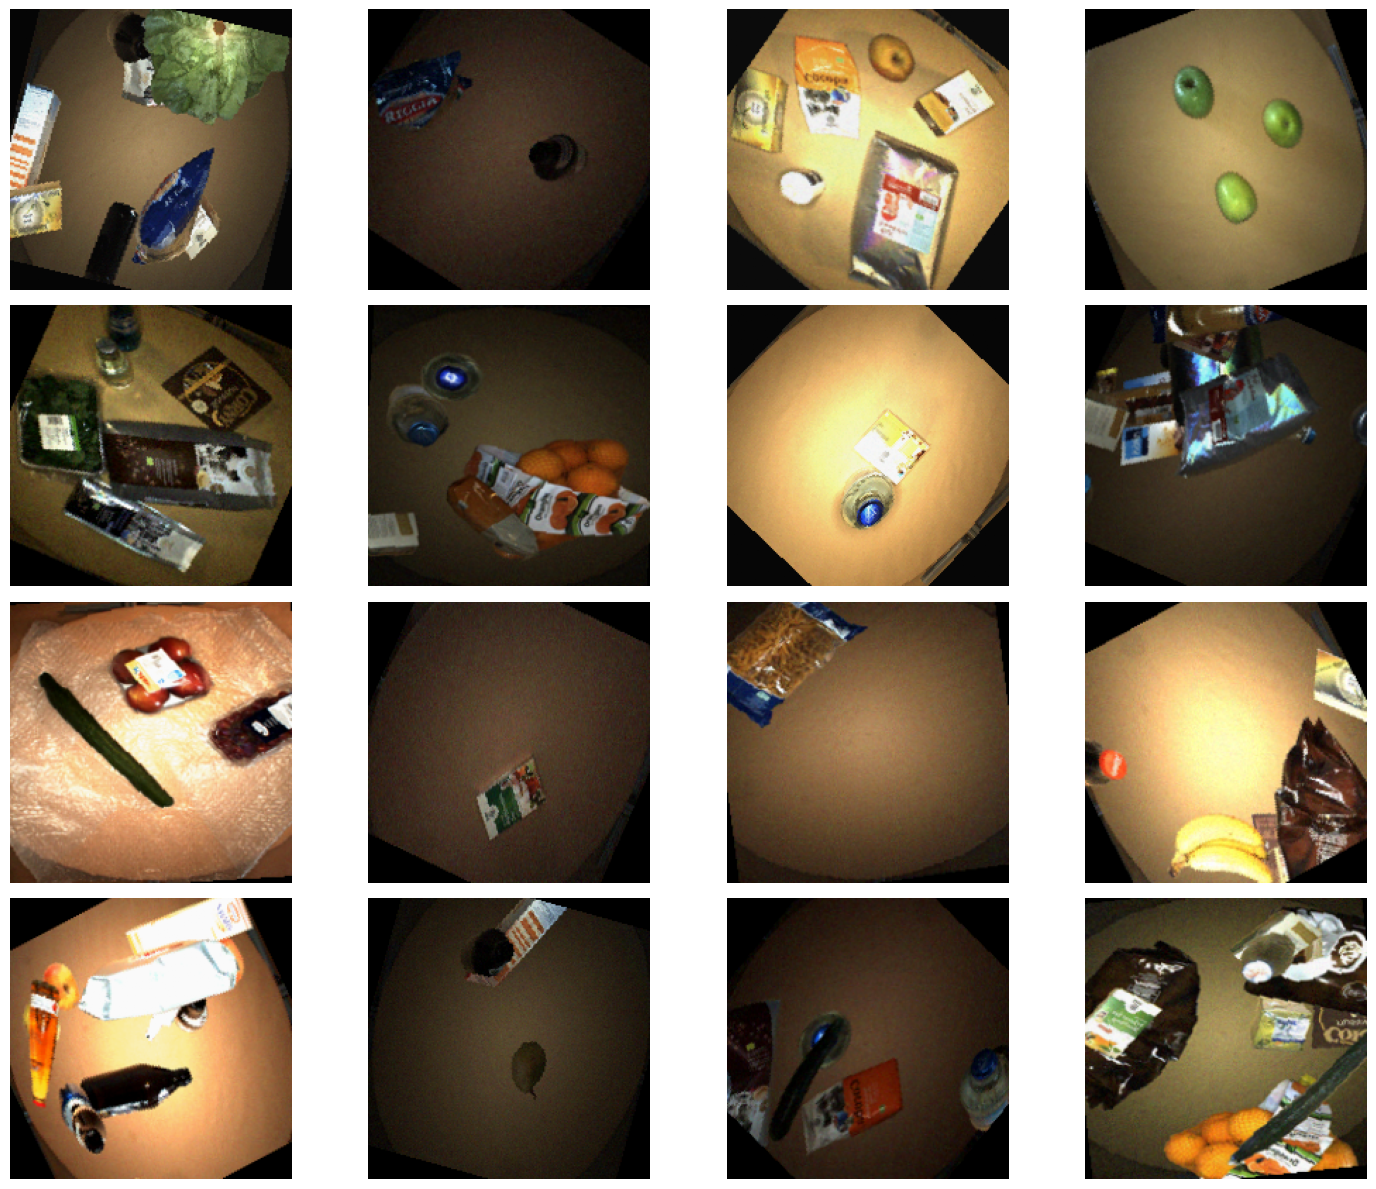

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Funktion zum Anzeigen von Bildern
def imshow(image, ax=None):
    # Wenn kein Ax angegeben wird, erstelle eine neue Achse
    if ax is None:
        fig, ax = plt.subplots()
        
    # Wandle den Tensor in ein NumPy-Array um und skaliere die Werte zurück auf [0, 1]
    image = image.permute(1, 2, 0).numpy()  # Von (C, H, W) nach (H, W, C)
    image = np.clip(image, 0, 1)  # Begrenze den Wertebereich auf [0, 1]
    
    ax.imshow(image)
    ax.axis('off')

# Hole ein Batch von Bildern aus dem DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Zeige die ersten 5 Bilder im Batch
fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4 Zeilen, 5 Spalten
axes = axes.flatten()  # Flatten der 2D Achsenmatrix, um sie einfach zu durchlaufen

# Zeige die Bilder
for i in range(16):
    imshow(images[i], axes[i])  # Stelle jedes Bild in der jeweiligen Achse dar

# Zeige die Bilder
plt.tight_layout()  # Optimiert das Layout für bessere Übersicht
plt.show()


## Weights & Biases

## Build Model

In [24]:
# Lightning Module
class RegressionModel(pl.LightningModule):
    def __init__(self, num_layers=6, num_filters=[32,32,32,32,32,32], pooling = [[1,2,3],[4]], kernel_size=3, learning_rate=1e-3):
        super().__init__()
        layers = []
        in_channels = 3  # Input-Kanäle, z. B. RGB-Bilder
        self.learning_rate = learning_rate
        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, num_filters[i], kernel_size, padding="same", stride=1))
            layers.append(nn.ReLU())
            if i in pooling[0]: 
                layers.append(nn.MaxPool2d(kernel_size=2))
            elif i in pooling[1]:
                layers.append(nn.MaxPool2d(kernel_size=3))

            in_channels = num_filters[i]
        
        layers.append(nn.Flatten())
        layers.append(nn.Linear(num_filters[len(num_filters)-1]* 64, 100))  # Passe die Eingabegröße entsprechend an
        layers.append(nn.ReLU())
        layers.append(nn.Linear(100, 50)) 
        layers.append(nn.ReLU())
        layers.append(nn.Linear(50, 1))  # Regression Output
        
        self.model = nn.Sequential(*layers)
        self.criterion = nn.MSELoss()
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mse = torchmetrics.MeanSquaredError()
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)  # Entferne die überflüssige Dimension
        loss = self.criterion(y_pred, y)

        # Berechne zusätzliche Metriken
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Logs für Progress-Bar und Training
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_mae", mae, prog_bar=True, on_epoch=True)
        self.log("train_mse", mse, prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)  # Entferne die überflüssige Dimension
        loss = self.criterion(y_pred, y)

        # Berechne zusätzliche Metriken
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Logs für Validation
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_mae", mae, prog_bar=True, on_epoch=True)
        self.log("val_mse", mse, prog_bar=True, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)
        loss = self.criterion(y_pred, y)
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mae", mae, prog_bar=True)
        self.log("test_mse", mse, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Erstelle einen Scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.96)
        # Alternativ: andere Scheduler wie CosineAnnealingLR, ReduceLROnPlateau, etc.
        
        return [optimizer], [scheduler]
    
    #def train_dataloader(self):

        #return super().train_dataloader()
    
    #def val_dataloader(self):


## Training

In [28]:
def show_predictions(model, test_dataset, num_samples=20):
        model.eval()  # Setze das Modell in den Evaluierungsmodus
        samples = random.sample(range(len(test_dataset)), num_samples)  # Wähle zufällig Samples aus
        
        fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # Erstelle ein 4x5 Grid für die Bilder
        
        for i, idx in enumerate(samples):
            image, label = test_dataset[idx]  # Lade das Bild und das Label
            image_tensor = image.unsqueeze(0).to(model.device)  # Füge Batch-Dimension hinzu und verschiebe auf GPU/CPU
            
            # Vorhersage erzeugen
            with torch.no_grad():
                prediction = model(image_tensor).cpu().item()
            
            # Bild anzeigen
            ax = axes[i // 5, i % 5]
            ax.imshow(image.permute(1, 2, 0))  # Konvertiere das Tensor-Bild in HWC-Format
            ax.set_title(f"Label: {label:.2f}\nPrediction: {prediction:.2f}")
            ax.axis("off")
        
        plt.tight_layout()

        try:
            wandb.log({"predictions": wandb.Image(plt)})
        except Exception as e:
            print(f"Couldn't log predictions to wandb: {e}")

        plt.show()

def configure_wandb():
     pass        

### Callbacks:

In [29]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',   # Track validation loss
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Checkpoint file name
    save_top_k=1,  # Save only the best model (lowest val_loss)
    mode='min',  # We are minimizing validation loss
)

early_stopping = EarlyStopping(
    monitor="val_loss",  
    mode="min",      
    min_delta=0.1,
    patience=5,          
    verbose=True       
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 990 K  | train
1 | criterion | MSELoss           | 0      | train
2 | mae       | MeanAbsoluteError | 0      | train
3 | mse       | MeanSquaredError  | 0      | train
--------------------------------------------------------
990 K     Trainable params
0         Non-trainable params
990 K     Total params
3.962     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Best model saved at: /Users/mats/Local/Test/TinyML-MT/training-code/checkpoints/best-checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    47.307552337646484     │
│         test_mae          │     5.426389694213867     │
│         test_mse          │    47.307552337646484     │
└───────────────────────────┴───────────────────────────┘

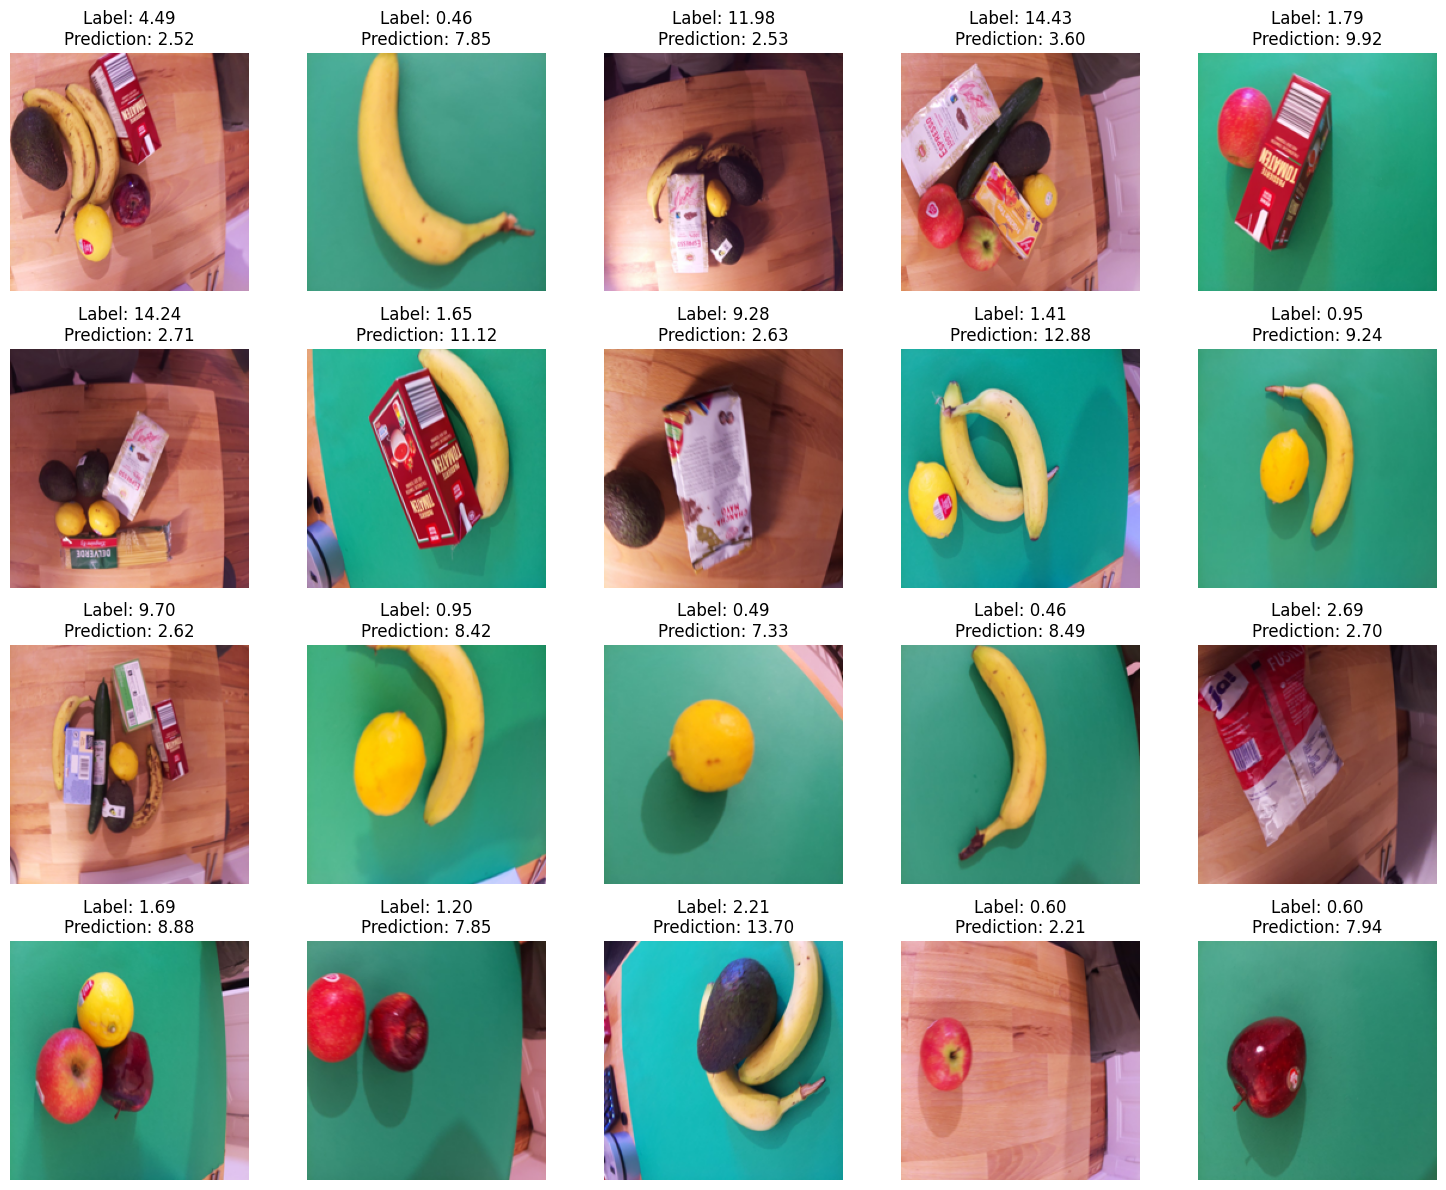

In [32]:
# WANDB stuff
#
# Sort the dataset names alphabetically
dataset_names = "-".join(sorted([os.path.basename(path) for path in DATASET_PATHS]))

group = "Regression-"+dataset_names
name = dataset_names+"_"+datetime.now().strftime("%d%b-%H:%M:%S")

wandb_logger = WandbLogger(project="TinyML-CartDetection", group=group, name=name)

model = RegressionModel(num_filters= [64, 64, 64, 64, 64, 96, 96, 96], num_layers=8, kernel_size=3, learning_rate= 0.001).to(device)

# Verschiebe das Modell auf das Gerät
#summary(model, input_size=(3, 200, 200))

# Log additional hyperparameters
wandb_logger.experiment.config.update({"batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "seed": SEED})

# Model training
try:
    trainer = pl.Trainer(max_epochs=100, logger=wandb_logger, callbacks=[checkpoint_callback], fast_dev_run=False, accelerator=str(device), devices=1)

    trainer.fit(model, train_loader, val_loader) 

    # Load the best checkpoint (lowest validation loss)
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model saved at: {best_model_path}")

    # Load the best model for testing
    model = RegressionModel.load_from_checkpoint(best_model_path)
    # Model Testing
    trainer.test(model, test_loader)

    # Metrics and predictions
    #metrics = trainer.callback_metrics

    show_predictions(model, test_dataset)
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    wandb.finish()


In [ ]:
NNs_grid_search_kernels = [[32, 32, 32, 32, 32, 32],[32, 32, 32, 16, 16, 8], [32, 64, 64, 64, 96, 96],[96, 96, 96, 96, 96, 96], [64, 64, 64, 64, 64, 64] ,[32, 64, 64, 64, 64, 64],[32, 32, 32, 32, 32, 32, 32], [32, 32, 32, 64, 64, 64, 64], [32, 32, 32, 64, 64, 64, 64, 64], [64, 64, 64, 64, 64, 96, 96, 96]]
NNs_grid_search_pooling_layers = [[[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,3],[4]], [[1,2,4],[5]], [[2,3,4],[5]], [[2,3,5],[6]], [[2,3,5],[6]]]  

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") Please use from the top for Mac support 

for i in range(len(NNs_grid_search_kernels)):

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',   # Track validation loss
        dirpath='checkpoints/',  # Directory to save checkpoints
        filename='best-checkpoint',  # Checkpoint file name
        save_top_k=1,  # Save only the best model (lowest val_loss)
        mode='min',  # We are minimizing validation loss
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",  
        mode="min",      
        min_delta=0.03,
        patience=8,          
        verbose=True       
)

    dataset_names = "-".join(sorted([os.path.basename(path) for path in DATASET_PATHS]))
    group = "Regression-"+dataset_names
    name = dataset_names+"_"+datetime.now().strftime("%d%b-%H:%M:%S")
    wandb_logger = WandbLogger(project="TinyML-CartDetection", group=group, name=name, tags=["GridSearch1"])
    wandb_logger.experiment.config.update({"batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "seed": SEED})
    checkpoint_callback.filename = name
    try:
        trainer = pl.Trainer(max_epochs=100, logger=wandb_logger, callbacks=[checkpoint_callback, early_stopping], fast_dev_run=False, accelerator=str(device), devices=1)

        model = RegressionModel(num_filters=NNs_grid_search_kernels[i], num_layers=len(NNs_grid_search_kernels[i]), kernel_size=3, learning_rate= 0.001).to(device)

        #summary(model, input_size=(3, 200, 200))

        trainer.fit(model, train_loader, val_loader) 

        # Load the best checkpoint (lowest validation loss)
        best_model_path = checkpoint_callback.best_model_path

        # Load the best model for testing
        model = RegressionModel.load_from_checkpoint(best_model_path)
        trainer.test(model, test_loader)

        # Metrics and predictions
        #metrics = trainer.callback_metrics
        show_predictions(model, test_dataset)

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        wandb.finish()    

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mats/miniconda3/envs/ML/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/mats/Local/Test/TinyML-MT/training-code/checkpoints exists and is not empty.

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 257 K  | train
1 | criterion | MSELoss           | 0      | train
2 | mae       | MeanAbsoluteError | 0      | train
3 | mse       | MeanSquaredError  | 0      | train
--------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 17.360


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.930 >= min_delta = 0.03. New best score: 16.430


Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12fe54860>
Traceback (most recent call last):
  File "/Users/mats/miniconda3/envs/ML/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/Users/mats/miniconda3/envs/ML/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/mats/miniconda3/envs/ML/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mats/miniconda3/envs/ML/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mats/miniconda3/envs/ML/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  

In [1]:
wandb.finish()

NameError: name 'wandb' is not defined